<a href="https://colab.research.google.com/github/supertime1/PPG_DSP/blob/main/PPG_DSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/DSP')

In [2]:
import util
from util import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from numba import jit
import glob
import sklearn
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from sklearn import preprocessing

## Import signal

In [3]:
file_path = r"C:\Users\57lzhang.US04WW4008\Downloads\OneDrive_1_1-5-2021"
file_name = "Sitting_+_Automatic_Cuff[1].csv"
df = read_data(file_path, file_name)
ps2 = df['ps2']
acc_x = df['x'].dropna()
acc_y = df['y'].dropna()
acc_z = df['z'].dropna()
acc = np.sqrt(np.square(acc_x) + np.square(acc_y) + np.square(acc_z))
df.head()

,Timestamp of Read Request [HH:mm:ss.MM],Estimated sample time [HH:mm:ss.MM],alsVis,alsIr,ps1,ps2,ps3,Temperature,x,y,z,ppgValid,accValid,Activity
0,11:27:30.878,11:27:28.878,0,300,25813,14992,0,0.0,-2108,1080,3486,1,1,NaN
1,11:27:30.878,11:27:28.888,0,295,25836,14996,0,0.0,-2115,1084,3473,1,1,NaN
2,11:27:30.878,11:27:28.898,0,294,25854,15019,0,0.0,-2111,1080,3465,1,1,NaN
3,11:27:30.878,11:27:28.908,0,295,25859,15019,0,0.0,-2106,1076,3464,1,1,NaN
4,11:27:30.878,11:27:28.918,0,297,25864,15026,0,0.0,-2097,1075,3472,1,1,NaN


##Remove motion artifacts (SpaMA algorithm)

In [4]:
def remove_motion_artifacts(ppg_signal, ppg_freq, acc_signal, 
                            acc_freq, cf_low=0.5, cf_high=3, time_span=5,
                            tolerance=1):
    """
    return a clean ppg_signal
    """
    
    assert len(ppg_signal) / ppg_freq == len(acc_signal) / acc_freq
    total_segs = len(ppg_signal) // (ppg_freq * time_span) 
    
    reconstructed_ppg = np.zeros(len(ppg_signal))
    original_filtered_ppg = np.zeros(len(ppg_signal))

    for i in range(total_segs):
        ppg_seg = ppg_signal[i * ppg_freq * time_span : (i+1) * ppg_freq * time_span]
        acc_seg = acc_signal[i * acc_freq * time_span : (i+1) * acc_freq * time_span]

        # 1. Apply bandpass filter to remove frequency band that is not of interests
        ppg_filtered = bw_filter(ppg_seg, ppg_freq, cf_low=cf_low, cf_high=cf_high, 
                                filter_type='band', order=4)
        ppg_filtered, _ = hampel_filter_forloop_numba(ppg_filtered, window_size=10, n_sigmas=3)
        acc_filtered = bw_filter(acc_seg, acc_freq, cf_low=cf_low, cf_high=cf_high, 
                                filter_type='band', order=4)
        # 2. FFT of ppg_signal and acc_signal (The interval is roughly 0.1Hz)
        # find the nearest power of 2
        ppg_fft_samples = int(2 ** np.ceil(np.log2(time_span * ppg_freq)))
        acc_fft_samples = int(2 ** np.ceil(np.log2(time_span * acc_freq)))

        ppg_fft_real = scipy.fft.rfft(ppg_filtered, ppg_fft_samples)
        acc_fft_real = scipy.fft.rfft(acc_filtered, acc_fft_samples)
        # 3. Detect the peak and amplitude of ppg_signal and acc_signal
        ppg_peaks_idx, ppg_property = scipy.signal.find_peaks(abs(ppg_fft_real), height = 10, distance=1)
        ppg_peaks_amp = ppg_property['peak_heights']

        acc_peaks_idx, acc_property = scipy.signal.find_peaks(abs(acc_fft_real), height = 10, distance=1)
        acc_peaks_amp = acc_property['peak_heights']

        # 4. Find the largest 3 peaks in ppg and the largest peak in acc 
        ppg_peaks_idx_list = [[idx, height] for idx, height in enumerate(ppg_peaks_amp)]
        ppg_peaks_idx_list.sort(key=lambda x: x[1], reverse=True)
        top_three_ppg_peaks = [i for i, _ in ppg_peaks_idx_list[:3]] # what if peaks num is smaller than 3
        ppg_largest_three_peaks = ppg_peaks_idx[top_three_ppg_peaks]
        
        acc_peaks_idx_list = [[idx, height] for idx, height in enumerate(acc_peaks_amp)]
        acc_peaks_idx_list.sort(key=lambda x: x[1], reverse=True)
        top_one_acc_peaks = [i for i, _ in acc_peaks_idx_list[:1]]
        acc_largest_one_peak = acc_peaks_idx[top_one_acc_peaks]

        # 5. Determine if motion artifacts presents in PPG signal
        corrupted_freq_idx = [i for i in ppg_largest_three_peaks if \
                              acc_largest_one_peak - tolerance <= i <= acc_largest_one_peak + tolerance]             
        # Case 1 and 2: if PPG signal is not corrupted or all frequencies are corrupted
        if len(corrupted_freq_idx) == 0 or len(corrupted_freq_idx) == len(ppg_largest_three_peaks):
            reconstructed_ppg[i * ppg_freq * time_span : (i+1) * ppg_freq * time_span] = ppg_filtered
            # also archive filtered ppg without reconstruction
            original_filtered_ppg[i * ppg_freq * time_span : (i+1) * ppg_freq * time_span] = ppg_filtered
            continue
        # Case 3: if 1 or 2 frequencies are corrupted
        # remove the corrupted frequency/frequencies
        for idx in corrupted_freq_idx:
            ppg_fft_real[idx] = 0
        # reconstruct the PPG signal
        reversed_ppg_filtered = scipy.fft.irfft(ppg_fft_real, ppg_fft_samples)
        reversed_ppg_filtered_time_span = reversed_ppg_filtered[:time_span * ppg_freq]
        reconstructed_ppg[i * ppg_freq * time_span : (i+1) * ppg_freq * time_span] = reversed_ppg_filtered_time_span
        
        # archive filtered ppg without reconstruction
        original_filtered_ppg[i * ppg_freq * time_span : (i+1) * ppg_freq * time_span] = ppg_filtered

    # for segment that is less than time span (e.g. 5 seconds)
    res = len(ppg_signal) % (ppg_freq * time_span) 
    res_ppg_filtered = bw_filter(ppg_signal[-res:], ppg_freq, cf_low=cf_low, cf_high=cf_high, 
                                filter_type='band', order=4)
    
    reconstructed_ppg[-res:] = res_ppg_filtered
    original_filtered_ppg[-res:] = res_ppg_filtered

    return reconstructed_ppg, original_filtered_ppg

In [ ]:
reconstructed_ppg, original_filtered_ppg = remove_motion_artifacts(ps2, 100, acc, 100)

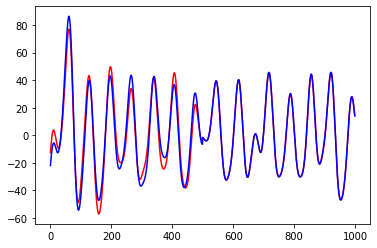

In [ ]:
plt.plot(reconstructed_ppg[:1000], 'r')
plt.plot(original_filtered_ppg[:1000], 'b')

##Spectrogram

In [ ]:
#unit of start and end is min
def plot_data(file_path, start, end):
  data_path = os.path.join(file_path, "*.csv")
  data_list=[]
  for name in glob.glob(data_path):
    df_temp = pd.read_csv(name, sep='\t', header=[0])
    #substract activity label from filename
    activity = name[name.index('\\')+1:name.index('.csv')] 
    data_list.append([df_temp,activity])
  
  fig, axes = plt.subplots(3,len(data_list), figsize=(20,12))

  for i in range(len(data_list)):
    df = data_list[i][0]
    raw_ps2 = df['ps2'][int(start*6000) : int(end*6000)]
    #bandpass filter
    ps2 = bw_filter(raw_ps2, 100, cf_low=0.5, cf_high=4, filter_type='band')
    #hampel fitler
    ps2, _ = hampel_filter_forloop_numba(ps2, 500, 3)
    #rescale signal
    ps2 = sklearn.preprocessing.minmax_scale(ps2, (-1,1))
    #perfusion index
    perfuse_index = perfusion_index(raw_ps2, fs=100)
    #signal to noise ratio
    snr = signal_noise_ratio(raw_ps2, fs=100)
    
    acc_x = df['x'][int(start*6000) : int(end*6000)].dropna()
    acc_y = df['y'][int(start*6000) : int(end*6000)].dropna()
    acc_z = df['z'][int(start*6000) : int(end*6000)].dropna()
    acc = np.sqrt(np.square(acc_x) + np.square(acc_y) + np.square(acc_z))
    acc -= np.mean(acc)
    activity = data_list[i][1]

    #PPG figure
    axes[0][i].plot(ps2, 'g', label='Raw PPG signal')
    axes[0][i].text(0.95, 0.05, 'Perfuion Index: ' + str(round(perfuse_index, 2))
                    + '\n' + 'Signal-to-Noise ratio: ' + str(round(snr, 2)),
                    verticalalignment='bottom', horizontalalignment='right',
                    transform=axes[0][i].transAxes,
                    color='black', fontsize=10,
                    bbox={'facecolor': 'white'})
    axes[0][i].set_title(activity, fontsize='15') 
    axes[0][i].legend()
    axes[0][i].set_xlabel('Samples')
    axes[0][i].set_ylabel('Rescaled ADC counts')
    
    #ACC figure
    axes[1][i].plot(acc, 'r', label='Accelerometer')
    axes[1][i].legend()
    axes[1][i].set_xlabel('Samples')
    axes[1][i].set_ylabel('ADC counts')

    #spectrogram
    ppg_freqs, ppg_times, ppg_Sx = scipy.signal.spectrogram(raw_ps2, fs=100, window='hanning',
                                                        nperseg=1024, noverlap=768,
                                                        detrend=False, scaling='spectrum')
     
    ppg_freqs_new = ppg_freqs[(ppg_freqs <= 6) & (ppg_freqs > 0.5)]
    ppg_Sx_new = np.log(ppg_Sx[(ppg_freqs <= 6) & (ppg_freqs > 0.5)])
    im = axes[2][i].pcolormesh(ppg_times, ppg_freqs_new, ppg_Sx_new)
    fig.colorbar(im, ax=axes[2][i])
    axes[2][i].set_xlabel('Time (s)')
    axes[2][i].set_ylabel('Frequency (Hz)')

  plt.show()

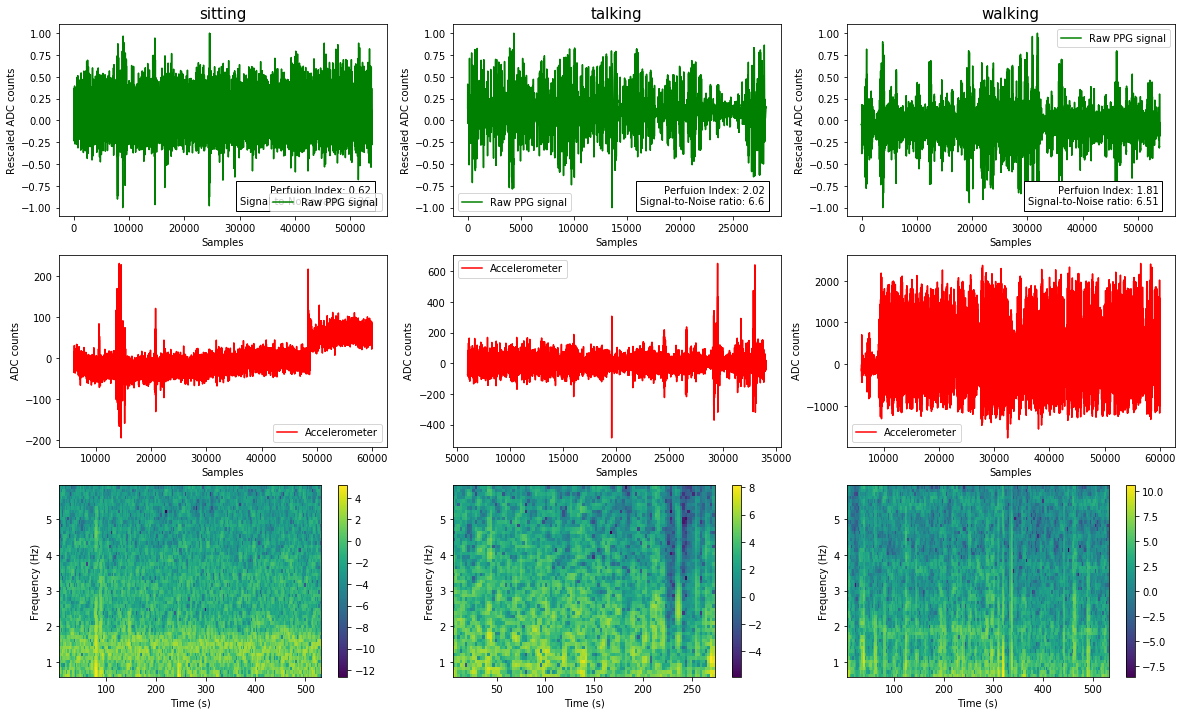

In [ ]:
file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Floyer data/Floyer prototype/data/AF/"
plot_data(file_path, 1, 10)

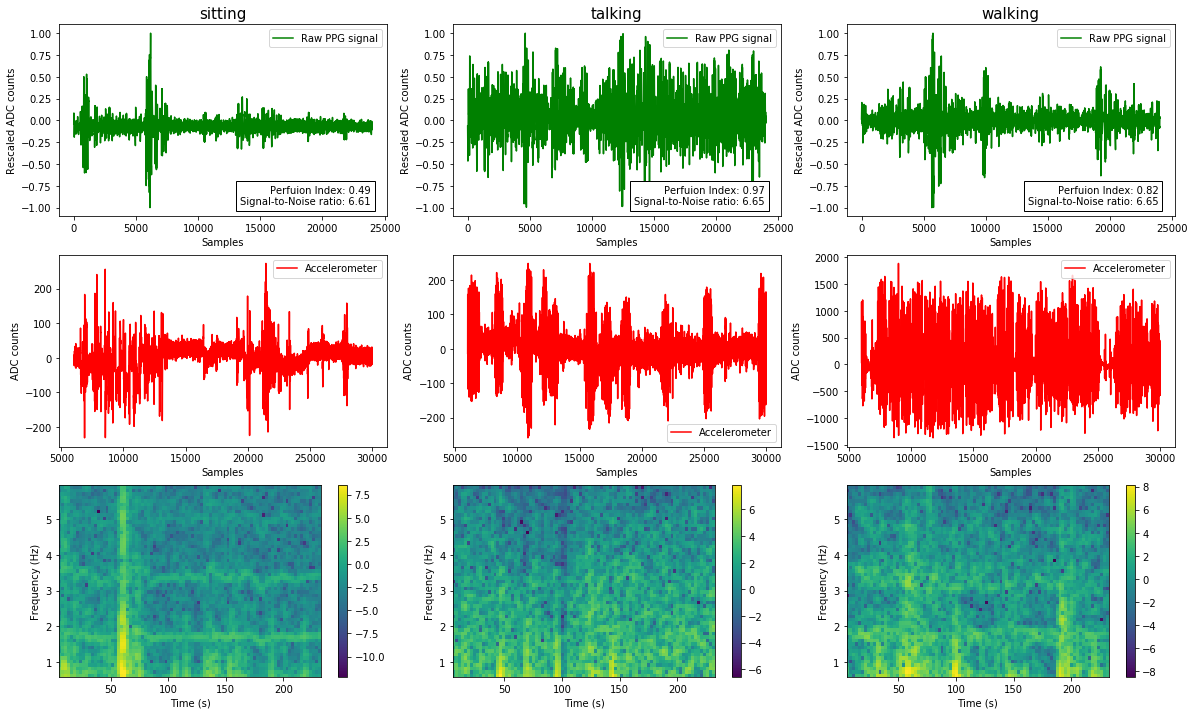

In [ ]:
file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Floyer data/Floyer prototype/data/NSR/"
plot_data(file_path, 1, 5)

In [ ]:
#unit of start and end is min
def plot_single_data(file_path, start, end):
  data_path = os.path.join(file_path, "*.csv")
  data_list=[]
  for name in glob.glob(data_path):
    df_temp = pd.read_csv(name, sep='\t', header=[0])
    #substract activity label from filename
    activity = name[name.index('\\')+1:name.index('.csv')] 
    data_list.append([df_temp,activity])
  
  fig, axes = plt.subplots(3, len(data_list), figsize=(15,12))

  for i in range(len(data_list)):
    df = data_list[i][0]
    raw_ps2 = df['ps2'][int(start*6000) : int(end*6000)]
    #bandpass filter
    ps2 = bw_filter(raw_ps2, 100, cf_low=0.5, cf_high=4, filter_type='band')
    #hampel fitler
    ps2, _ = hampel_filter_forloop_numba(ps2, 500, 3)
    #rescale signal
    ps2 = sklearn.preprocessing.minmax_scale(ps2, (-1,1))
    #perfusion index
    perfuse_index = perfusion_index(raw_ps2, fs=100)
    #signal to noise ratio
    snr = signal_noise_ratio(raw_ps2, fs=100)
    
    acc_x = df['x'][int(start*6000) : int(end*6000)].dropna()
    acc_y = df['y'][int(start*6000) : int(end*6000)].dropna()
    acc_z = df['z'][int(start*6000) : int(end*6000)].dropna()
    acc = np.sqrt(np.square(acc_x) + np.square(acc_y) + np.square(acc_z))
    acc -= np.mean(acc)
    activity = data_list[i][1]

    #PPG figure
    axes[0].plot(ps2, 'g', label='Raw PPG signal')
    axes[0].text(0.95, 0.05, 'Perfuion Index: ' + str(round(perfuse_index, 2))
                    + '\n' + 'Signal-to-Noise ratio: ' + str(round(snr, 2)),
                    verticalalignment='bottom', horizontalalignment='right',
                    transform=axes[0].transAxes,
                    color='black', fontsize=10,
                    bbox={'facecolor': 'white'})
    axes[0].set_title(activity, fontsize='15') 
    axes[0].legend()
    axes[0].set_xlabel('Samples')
    axes[0].set_ylabel('Rescaled ADC counts')
    
    #ACC figure
    axes[1].plot(acc, 'r', label='Accelerometer')
    axes[1].legend()
    axes[1].set_xlabel('Samples')
    axes[1].set_ylabel('ADC counts')

    #spectrogram
    ppg_freqs, ppg_times, ppg_Sx = scipy.signal.spectrogram(raw_ps2, fs=100, window='hanning',
                                                        nperseg=1024, noverlap=768,
                                                        detrend=False, scaling='spectrum')
     
    ppg_freqs_new = ppg_freqs[(ppg_freqs <= 6) & (ppg_freqs > 0.5)]
    ppg_Sx_new = np.log(ppg_Sx[(ppg_freqs <= 6) & (ppg_freqs > 0.5)])
    im = axes[2].pcolormesh(ppg_times, ppg_freqs_new, ppg_Sx_new)
    fig.colorbar(im, ax=axes[2])
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Frequency (Hz)')

  plt.show()

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


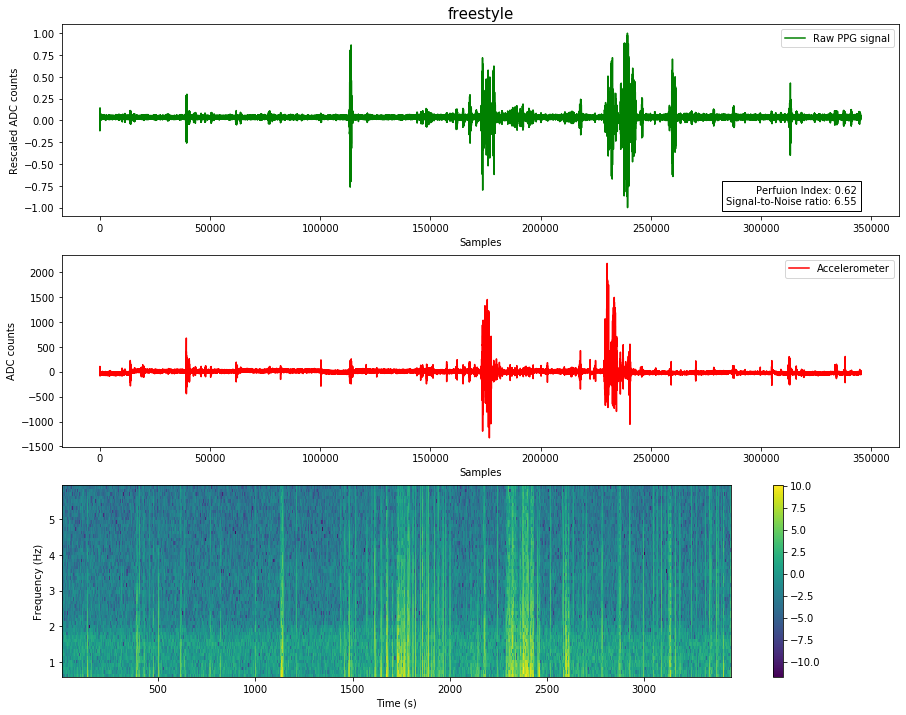

In [ ]:
file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Floyer data/Floyer prototype/data/"
plot_single_data(file_path, 0, 60)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


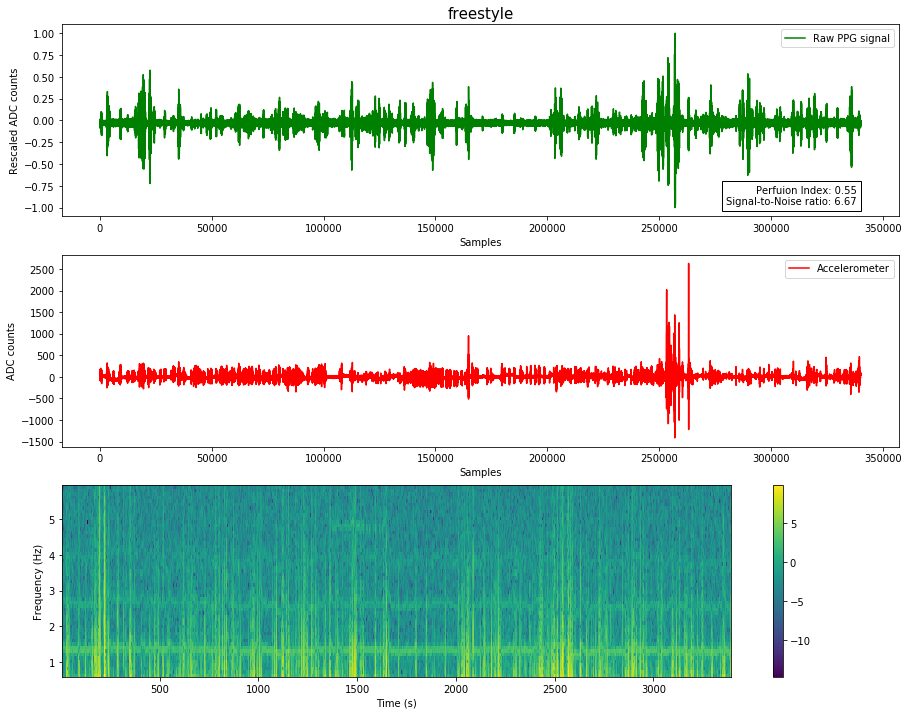

In [ ]:
file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Floyer data/Floyer prototype/data/"
plot_single_data(file_path, 0, 60)

## Visualize the imported signal

In [23]:
def plot_ps2_acc(file_path, file_name, range, view_in_time=True,
                 zoom_in=False):
    """
    range: time range in min that the figure will show
    """

    df = read_data(file_path, file_name)
    ps2 = df['ps1']
    acc_x = df['x'].dropna()
    acc_y = df['y'].dropna()
    acc_z = df['z'].dropna()
    acc = np.sqrt(np.square(acc_x) + np.square(acc_y) + np.square(acc_z))
    
    fig, axes = plt.subplots(4, figsize=(12,16))
    new_x = np.linspace(0, len(ps2), len(ps2)//10)
    
    if view_in_time:
        scale = 1/100
    else:
        scale = 1
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))

    signal = ps2
    re_signal, original_filtered = remove_motion_artifacts(ps2, 100, acc, 100)
    
    resample_signal = scipy.signal.resample(ps2, int(len(ps2)/10))
    #PPG figure
    axes[0].plot(signal, 'g', label='Raw PPG signal')
    axes[0].set_title(file_name +'\n\n' + 'Raw PPG signal', fontsize='15')
    axes[0].set_xlim([6000*range[0], 6000*range[1]])
    axes[0].legend()
    axes[0].xaxis.set_major_formatter(ticks)
    axes[0].xaxis.set_major_locator(MultipleLocator(6000))
    axes[0].grid(which='major', color='#CCCCCC', linestyle='--')
    
    #PPG figure
    axes[1].plot(original_filtered, 'b', label='Band pass filtered PPG signal')
    axes[1].set_title('Band pass filtered PPG signal', fontsize='15')
    axes[1].set_xlim([6000*range[0], 6000*range[1]])
    if zoom_in:
        axes[1].set_ylim(-25, 25) 
    axes[1].legend()
    axes[1].xaxis.set_major_formatter(ticks)
    axes[1].xaxis.set_major_locator(MultipleLocator(6000))
    axes[1].grid(which='major', color='#CCCCCC', linestyle='--')

    #PPG figure
    axes[2].plot(new_x, np.gradient(resample_signal,1), 'y', label='First order derivative filtered PPG signal')
    axes[2].set_title('First order derivative filtered PPG signal', fontsize='15')
    axes[2].set_xlim([6000*range[0], 6000*range[1]])
    if zoom_in:
        axes[2].set_ylim(-25, 25) 
    axes[2].legend()
    axes[2].xaxis.set_major_formatter(ticks)
    axes[2].xaxis.set_major_locator(MultipleLocator(6000))
    axes[2].grid(which='major', color='#CCCCCC', linestyle='--')


    #ACC figure
    axes[3].plot(acc, 'r', label='Accelerometer')
    axes[3].set_title('Accelerometer', fontsize='15')
    axes[3].set_xlim([6000*range[0], 6000*range[1]])
    axes[3].legend()
    axes[3].xaxis.set_major_formatter(ticks)
    axes[3].xaxis.set_major_locator(MultipleLocator(6000))
    axes[3].grid(which='major', color='#CCCCCC', linestyle='--')

    # Set common labels
    fig.text(0.5, 0.08, 'Time (s)', ha='center', va='baseline', fontsize='15')
    fig.text(0.06, 0.5, 'ADC counts', ha='center', va='center', rotation='vertical',
            fontsize='15')
    plt.show()

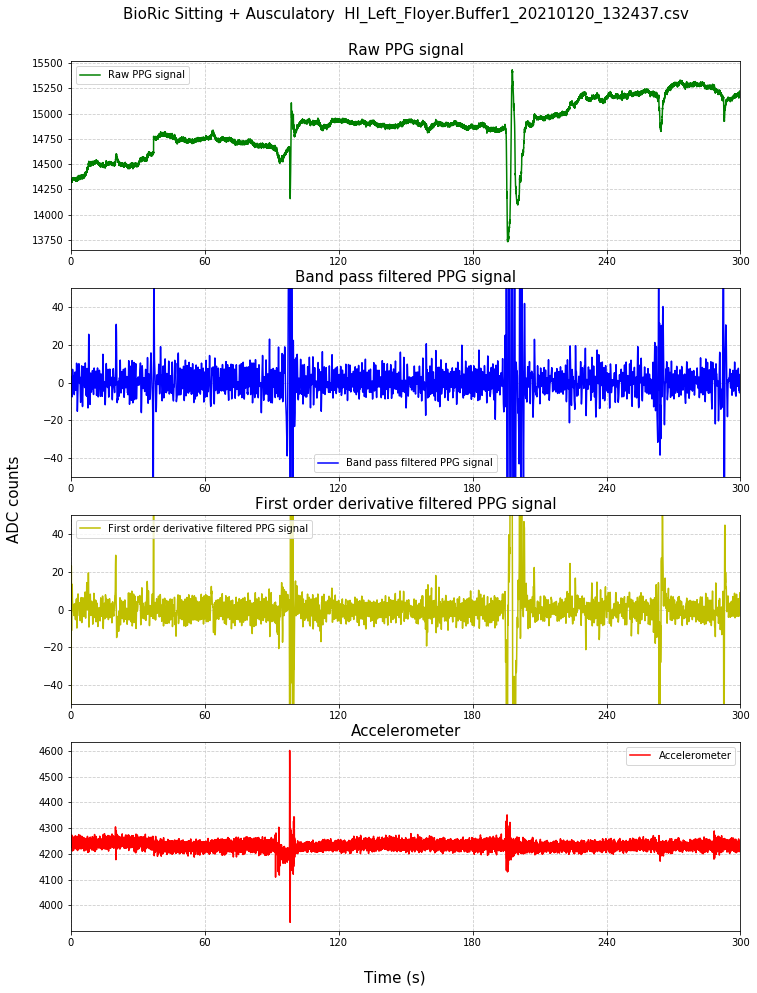

In [19]:
file_path = "C:/Users/57lzhang.US04WW4008/Downloads/OneDrive_2021-01-25/Test 2/MiA Test 2/BioRic"
file_name = "BioRic Sitting + Ausculatory  HI_Left_Floyer.Buffer1_20210120_132437.csv"
data_path = os.path.join(file_path, file_name)
plot_ps2_acc(file_path, file_name, [0,5], 
             view_in_time=True, zoom_in=True)

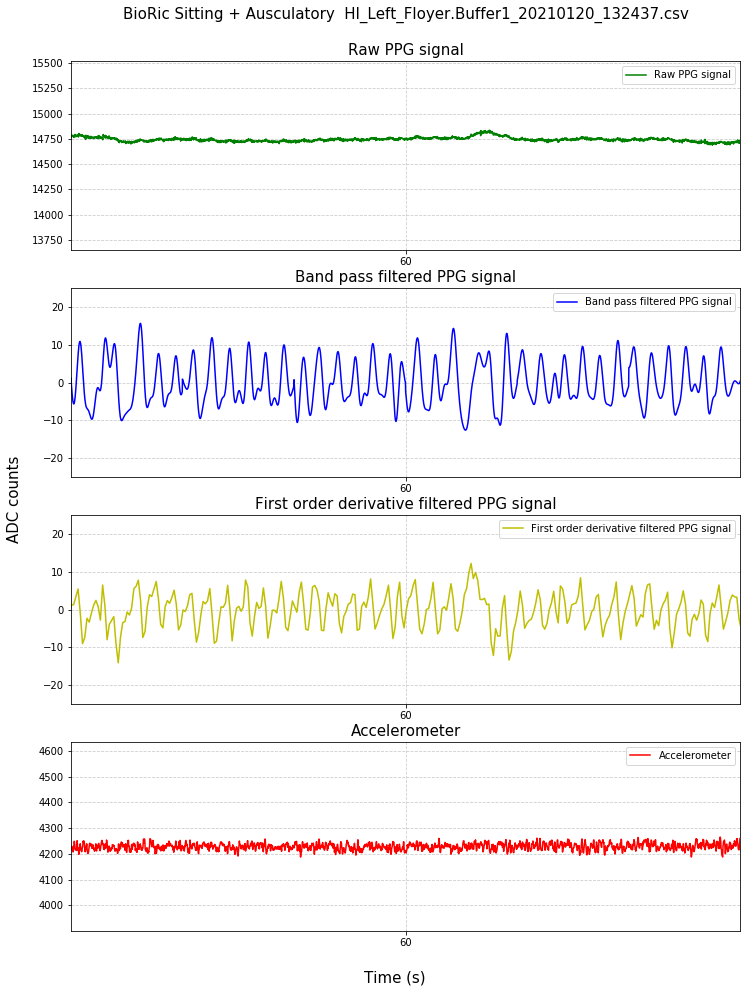

In [24]:
file_path = "C:/Users/57lzhang.US04WW4008/Downloads/OneDrive_2021-01-25/Test 2/MiA Test 2/BioRic"
file_name = "BioRic Sitting + Ausculatory  HI_Left_Floyer.Buffer1_20210120_132437.csv"
data_path = os.path.join(file_path, file_name)
plot_ps2_acc(file_path, file_name, [0.75,1.25], 
             view_in_time=True, zoom_in=True)

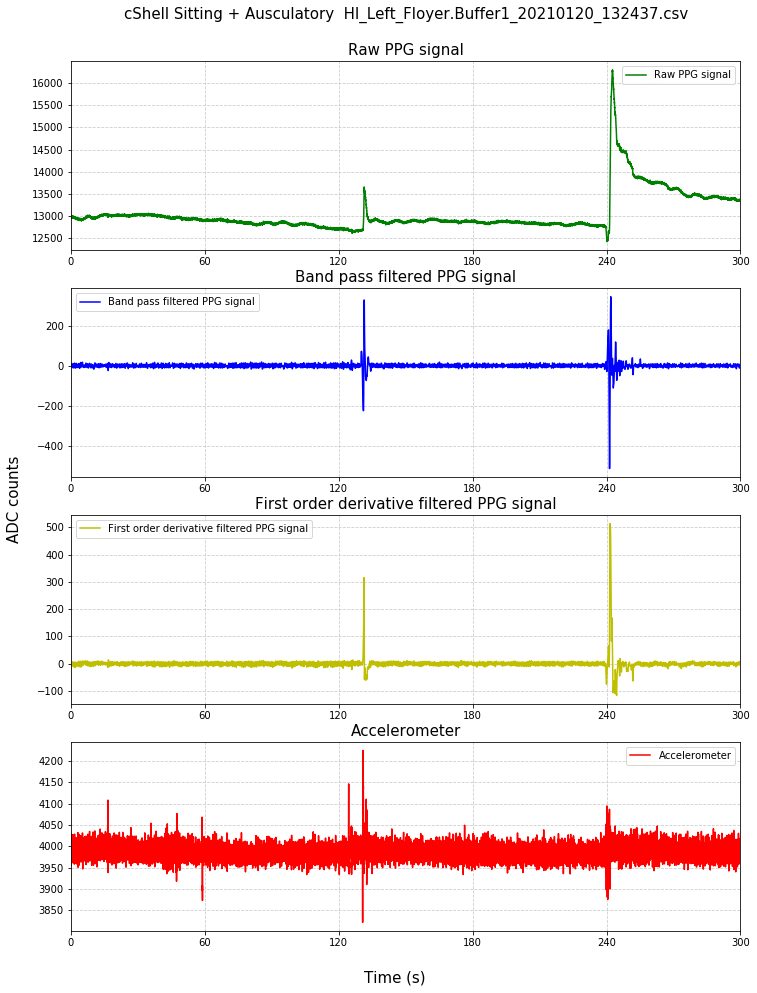

In [25]:
file_path = "C:/Users/57lzhang.US04WW4008/Downloads/OneDrive_2021-01-25/Test 2/MiA Test 2/cShell"
file_name = "cShell Sitting + Ausculatory  HI_Left_Floyer.Buffer1_20210120_132437.csv"
data_path = os.path.join(file_path, file_name)
plot_ps2_acc(file_path, file_name, [0,5], 
             view_in_time=True, zoom_in=False)

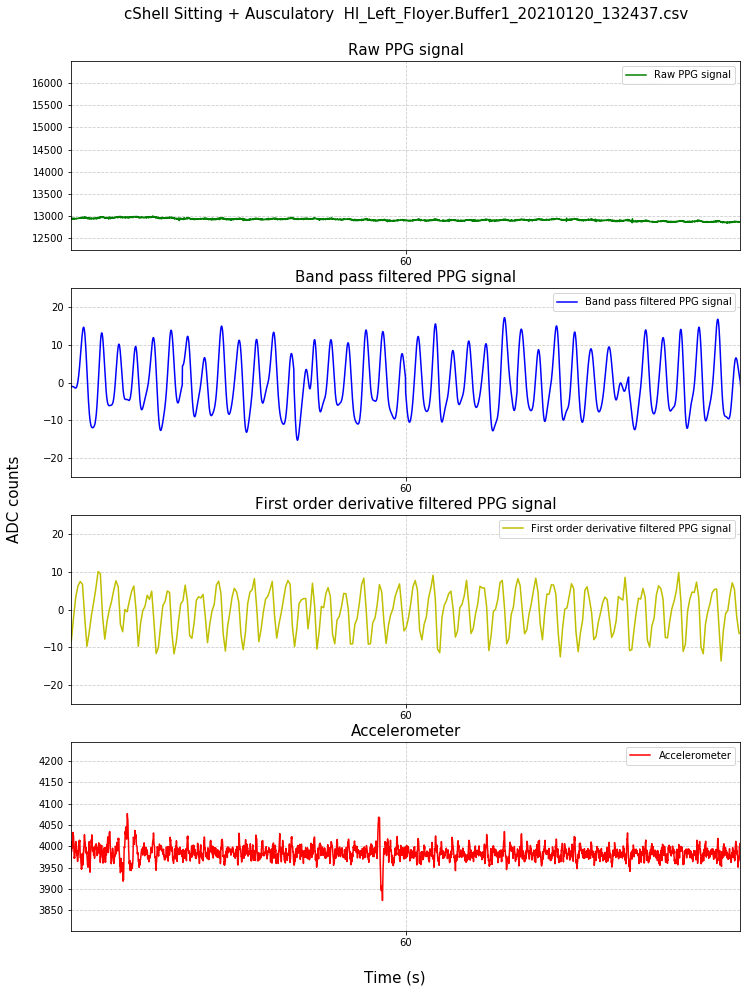

In [26]:
file_path = "C:/Users/57lzhang.US04WW4008/Downloads/OneDrive_2021-01-25/Test 2/MiA Test 2/cShell"
file_name = "cShell Sitting + Ausculatory  HI_Left_Floyer.Buffer1_20210120_132437.csv"
data_path = os.path.join(file_path, file_name)
plot_ps2_acc(file_path, file_name, [0.75,1.25], 
             view_in_time=True, zoom_in=True)

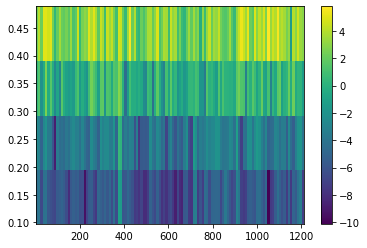

In [ ]:
#filter_ps2 = bw_filter(ps2, 100, cf_low=0.5, cf_high=3, filter_type='band', order=4)
ppg_freqs, ppg_time, ppg_Sx = scipy.signal.spectrogram(filter_ps2,fs=100, window='hanning',nperseg=1024, noverlap=0, detrend=False, scaling='spectrum')
ppg_freqs_new = ppg_freqs[(ppg_freqs <= 0.5) & (ppg_freqs > 0.0)]
ppg_Sx_new = np.log(ppg_Sx[(ppg_freqs <= 0.5) & (ppg_freqs > 0.0)])
plt.pcolormesh(ppg_time, ppg_freqs_new, ppg_Sx_new)
plt.colorbar()

##Perfusion Index

In [ ]:
p_idx = perfusion_index(ps2, 100, order=4)
print('The perfusion index (AC-DC ratio) is:', round(p_idx,2), '%')

The perfusion index (AC-DC ratio) is: 0.44 %


##Signal-to-Noise Ratio

In [ ]:
#calculte SNR
snr = signal_noise_ratio(ps2)
print('The SNR (signal to noise ratio) is:', round(snr,2))

The SNR (signal to noise ratio) is: 6.63


##Band Pass Filter

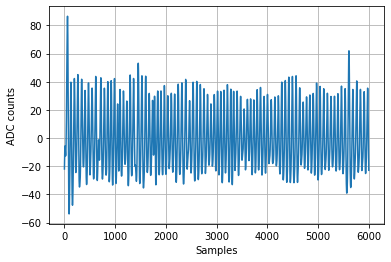

In [ ]:
#band pass
signal = bw_filter(ps2, fs=100, filter_type='band')
plt.plot(signal[:6000], label='banpass filtered signal')
plt.xlabel('Samples')
plt.ylabel('ADC counts')
plt.grid()

##Hample Filter

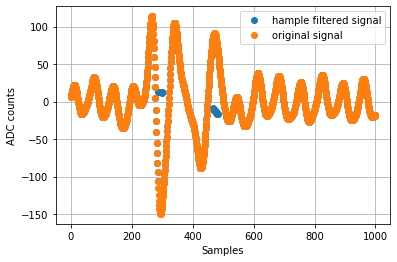

In [ ]:
#hample filter
hf_signal, _ = hampel_filter_forloop_numba(signal,100,3)
plt.plot(hf_signal[11500:12500], 'o', label='hample filtered signal')
plt.plot(signal[11500:12500], 'o', label='original signal')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('ADC counts')
plt.grid()

##Signal Quality Checker

### Visualize the resampled signal

In [ ]:
order = 4
fs = 100
cf_low = 0.5
cf_high = 3
h_b, h_a = scipy.signal.iirfilter(order, [cf_low / fs * 2, cf_high / fs * 2],
                                  btype='bandpass', analog=False,
                                  ftype='butter')
ps2_filtered = scipy.signal.filtfilt(h_b, h_a, ps2)

In [ ]:
ps2_resample = scipy.signal.resample(ps2_filtered, int(len(ps2)/10))
print('Resampled signal lengh:', len(ps2_resample))
print('Orignal signal length:', len(ps2))

Resampled signal lengh: 12572
Orignal signal length: 125725


In [ ]:
x = np.linspace(0, 1400, len(ps2), endpoint=False)
y = ps2_filtered
xnew = np.linspace(0, 1400, len(ps2_resample), endpoint=False)
y2 = ps2_resample

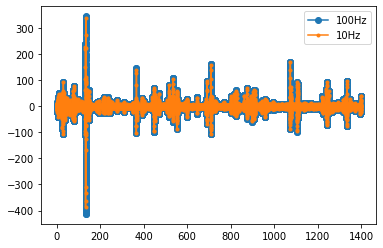

In [ ]:
plt.plot(x, y, 'o-',label = '100Hz')
plt.plot(xnew, y2, '.-', label = '10Hz')
plt.legend()

###Calculate the quality factor of signal

In [ ]:
qf_lst = here_qf_checker(y, 100, cf_low=0.5, cf_high=3, order=4)

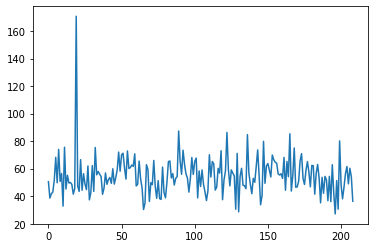

In [ ]:
plt.plot(qf_lst)